# Fraud detection on unlabelled data using Keras & Tensor Flow

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import pickle

from sqlalchemy import create_engine
import sqlite3
from pandas.io import sql

#Plan
#Load the csv file to pandas
# clean it
#
#credit card fraud
#Dataset: https://www.kaggle.com/mlg-ulb/creditcardfraud
#  reference: https://medium.com/@curiousily/credit-card-fraud-detection-using-autoencoders-in-keras-tensorflow-for-hackers-part-vii-20e0c85301bd

from scipy import stats
from sklearn.model_selection import train_test_split




from keras.models import Model, load_model
from keras.layers import Dense
from keras import regularizers
from keras.callbacks import ModelCheckpoint, TensorBoard

from sklearn.model_selection import train_test_split



Using TensorFlow backend.


In [0]:
import keras as ks
from keras.layers import *
from keras.models import *
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.initializers import *
from keras.optimizers import *
import keras.backend as K
from keras.callbacks import *
import tensorflow as tf
from keras.preprocessing.sequence import pad_sequences
from smart_open import smart_open
import datetime 
from keras.utils import multi_gpu_model

from keras.layers import Input



sns.set(style='whitegrid', palette='muted', font_scale=1.5)

#rcParams['figure.figsize'] = 14, 8


LABELS = ["Normal", "Fraud"]



In [4]:
####Fraud Detection...creditcard.csv
csv_file = 'creditcard.csv'
CCard= pd.read_csv(csv_file, encoding = 'utf-8',delimiter = ',')
# If you don't specify the type encoding as `utf-8`, you're going to have a difficult time when you try to convert to SQL.
CCard.head(10)
##Not labeled,imbalanced,
#Transformed by PCA into numerical values

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0.0
1,0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0.0
2,1,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0.0
3,1,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0.0
4,2,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0.0
5,2,-0.425966,0.960523,1.141109,-0.168252,0.420987,-0.029728,0.476201,0.260314,-0.568671,-0.371407,1.341262,0.359894,-0.358091,-0.137134,0.517617,0.401726,-0.058133,0.068653,-0.033194,0.084968,-0.208254,-0.559825,-0.026398,-0.371427,-0.232794,0.105915,0.253844,0.081080,3.67,0.0
6,4,1.229658,0.141004,0.045371,1.202613,0.191881,0.272708,-0.005159,0.081213,0.464960,-0.099254,-1.416907,-0.153826,-0.751063,0.167372,0.050144,-0.443587,0.002821,-0.611987,-0.045575,-0.219633,-0.167716,-0.270710,-0.154104,-0.780055,0.750137,-0.257237,0.034507,0.005168,4.99,0.0
7,7,-0.644269,1.417964,1.074380,-0.492199,0.948934,0.428118,1.120631,-3.807864,0.615375,1.249376,-0.619468,0.291474,1.757964,-1.323865,0.686133,-0.076127,-1.222127,-0.358222,0.324505,-0.156742,1.943465,-1.015455,0.057504,-0.649709,-0.415267,-0.051634,-1.206921,-1.085339,40.80,0.0
8,7,-0.894286,0.286157,-0.113192,-0.271526,2.669599,3.721818,0.370145,0.851084,-0.392048,-0.410430,-0.705117,-0.110452,-0.286254,0.074355,-0.328783,-0.210077,-0.499768,0.118765,0.570328,0.052736,-0.073425,-0.268092,-0.204233,1.011592,0.373205,-0.384157,0.011747,0.142404,93.20,0.0
9,9,-0.338262,1.119593,1.044367,-0.222187,0.499361,-0.246761,0.651583,0.069539,-0.736727,-0.366846,1.017614,0.836390,1.006844,-0.443523,0.150219,0.739453,-0.540980,0.476677,0.451773,0.203711,-0.246914,-0.633753,-0.120794,-0.385050,-0.069733,0.094199,0.246219,0.083076,3.68,0.0


In [5]:
CCard.describe(include = 'all')

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,15936.000000,15936.000000,15936.000000,15936.000000,15936.000000,15936.000000,15936.000000,15936.000000,15936.000000,15936.000000,15936.000000,15936.000000,15936.000000,15936.000000,15936.000000,15936.000000,15936.000000,15936.000000,15936.000000,15936.000000,15936.000000,15936.000000,15936.000000,15935.000000,15935.000000,15935.000000,15935.000000,15935.000000,15935.000000,15935.000000,15935.000000
mean,12121.217871,-0.254293,0.277171,0.803852,0.301343,-0.130469,0.112551,-0.150434,0.000687,0.860838,-0.287880,0.803504,-1.387375,0.889951,0.729020,-0.135403,-0.033405,0.360732,-0.022175,-0.082943,0.031135,-0.061754,-0.162257,-0.036524,0.011509,0.117477,0.037900,0.015402,0.006161,66.390222,0.004581
std,8982.283843,1.843083,1.491497,1.704252,1.491713,1.382485,1.329406,1.321898,1.303509,1.253988,1.263167,1.200059,1.574790,1.181378,1.358061,0.979347,0.971423,1.268198,0.855653,0.825932,0.617084,0.855525,0.624614,0.543296,0.587200,0.436867,0.546881,0.401168,0.253739,189.355098,0.067531
min,0.000000,-28.344757,-40.978852,-27.368650,-5.172595,-32.092129,-23.496714,-26.548144,-23.632502,-7.175097,-14.166795,-2.767470,-17.769143,-3.389510,-19.214325,-4.152532,-12.227189,-18.587366,-8.061208,-4.932733,-13.276034,-11.468435,-8.593642,-26.751119,-2.512377,-7.495741,-1.338556,-8.567638,-3.575312,0.000000,0.000000
25%,3633.500000,-0.970824,-0.286548,0.371671,-0.621215,-0.712525,-0.639011,-0.600811,-0.179179,0.067089,-0.744874,-0.007598,-2.403243,0.045664,0.122064,-0.702791,-0.510461,-0.116974,-0.459945,-0.568901,-0.160833,-0.268829,-0.559341,-0.173003,-0.336475,-0.140144,-0.355523,-0.073563,-0.013205,5.490000,0.000000
50%,10980.000000,-0.318478,0.247437,0.941822,0.231366,-0.186241,-0.160812,-0.084696,0.017471,0.851878,-0.352155,0.753609,-1.707884,0.952180,0.984915,-0.001974,0.044005,0.361666,0.026846,-0.087679,-0.034371,-0.127164,-0.126343,-0.044512,0.060331,0.155636,-0.027574,0.001209,0.017630,15.950000,0.000000
75%,20621.500000,1.161949,0.884689,1.575960,1.180124,0.352221,0.501828,0.440006,0.266216,1.567643,0.154114,1.594331,-0.043952,1.778463,1.511918,0.528986,0.537823,0.851845,0.479125,0.433110,0.145070,0.027233,0.229727,0.072765,0.393416,0.393032,0.359173,0.100782,0.076575,53.890000,0.000000
max,27371.000000,1.960497,14.601998,4.101716,11.927512,34.099309,21.393069,34.303177,17.052566,10.392889,12.701539,12.018913,3.774837,4.465413,7.692209,3.635042,4.816252,9.253526,4.295648,4.555359,13.849860,22.614889,4.534454,13.876221,3.695503,5.525093,3.517346,8.254376,4.860769,7712.430000,1.000000


In [6]:
CCard.Class.value_counts()   ### 492 fraud transactions, imbalanced..Class Fraud:1,  

0.0    15862
1.0       73
Name: Class, dtype: int64

In [7]:
CCard.shape

(15936, 31)

In [0]:
from sklearn.preprocessing import StandardScaler

data = CCard.drop(['Time'], axis=1)

data['Amount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))

In [0]:
#Reserving 20% for test 
seed = 42


X_train, X_test = train_test_split(data, random_state = seed , test_size = 0.2)

In [0]:
X_train = X_train[X_train.Class == 0]

In [11]:
X_train = X_train.drop(['Class'], axis=1)
y_test = X_test['Class']
X_test = X_test.drop(['Class'], axis=1)
X_train = X_train.values
X_test = X_test.values
X_train.shape

(12692, 29)

In [12]:
### building model
input_dim = X_train.shape[1]
encoding_dim = 14

input_layer = Input(shape=(input_dim, ))
encoder = Dense(encoding_dim, activation="tanh", 
                activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(int(encoding_dim / 2), activation="relu")(encoder)
decoder = Dense(int(encoding_dim / 2), activation='tanh')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)

Instructions for updating:
Colocations handled automatically by placer.


In [13]:
nb_epoch = 100
batch_size = 32
autoencoder.compile(optimizer='adam', 
                    loss='mean_squared_error', 
                    metrics=['accuracy'])
checkpointer = ModelCheckpoint(filepath="model.h5",
                               verbose=0,
                               save_best_only=True)
tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)
history = autoencoder.fit(X_train, X_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_test, X_test),
                    verbose=1,
                    callbacks=[checkpointer, tensorboard]).history

Instructions for updating:
Use tf.cast instead.
Train on 12692 samples, validate on 3188 samples
Epoch 1/100
12692/12692 [==============================] - 1s 48us/step - loss: 1.0690 - acc: 0.2758 - val_loss: 1.3667 - val_acc: 0.4332
Epoch 2/100
12692/12692 [==============================] - 0s 34us/step - loss: 0.9460 - acc: 0.4666 - val_loss: 1.3138 - val_acc: 0.5035
Epoch 3/100
12692/12692 [==============================] - 0s 37us/step - loss: 0.9101 - acc: 0.5065 - val_loss: 1.2837 - val_acc: 0.5151
Epoch 4/100
12692/12692 [==============================] - 0s 34us/step - loss: 0.8833 - acc: 0.5325 - val_loss: 1.2558 - val_acc: 0.5467
Epoch 5/100
12692/12692 [==============================] - 0s 34us/step - loss: 0.8571 - acc: 0.5502 - val_loss: 1.2275 - val_acc: 0.5561
Epoch 6/100
12692/12692 [==============================] - 0s 34us/step - loss: 0.8360 - acc: 0.5723 - val_loss: 1.2080 - val_acc: 0.5925
Epoch 7/100
12692/12692 [==============================] - 0s 34us/step - l

In [0]:
autoencoder = load_model('model.h5')

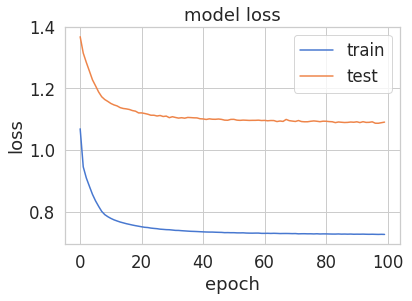

In [15]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

In [16]:
predictions = autoencoder.predict(X_test)
mse = np.mean(np.power(X_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': y_test})
error_df.describe()

,reconstruction_error,true_class
count,3188.000000,3188.000000
mean,1.080834,0.005646
std,6.350556,0.074940
min,0.059579,0.000000
25%,0.273931,0.000000
50%,0.428827,0.000000
75%,0.674973,0.000000
max,157.029924,1.000000


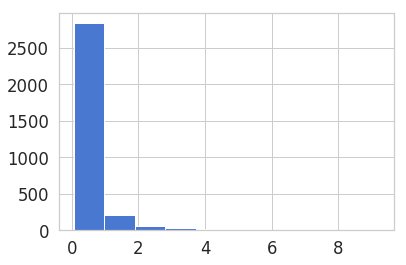

In [17]:
#  reconstuction without fraud
fig = plt.figure()
ax = fig.add_subplot(111)
normal_error_df = error_df[(error_df['true_class']== 0) & (error_df['reconstruction_error'] < 10)]
_ = ax.hist(normal_error_df.reconstruction_error.values, bins=10)

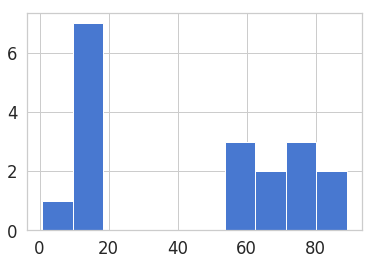

In [18]:
# #  reconstuction with fraud
fig = plt.figure()
ax = fig.add_subplot(111)
fraud_error_df = error_df[error_df['true_class'] == 1]
_ = ax.hist(fraud_error_df.reconstruction_error.values, bins=10)

In [0]:
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)



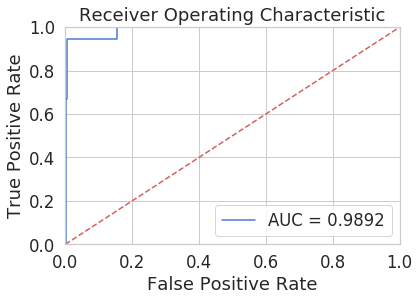

In [20]:
fpr, tpr, thresholds = roc_curve(error_df.true_class, error_df.reconstruction_error)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

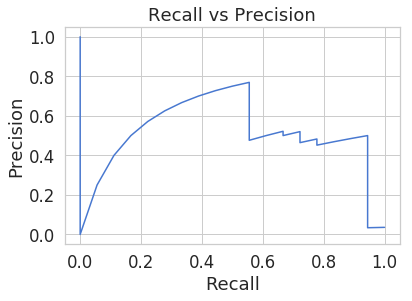

In [21]:
precision, recall, th = precision_recall_curve(error_df.true_class, error_df.reconstruction_error)
plt.plot(recall, precision, 'b', label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()



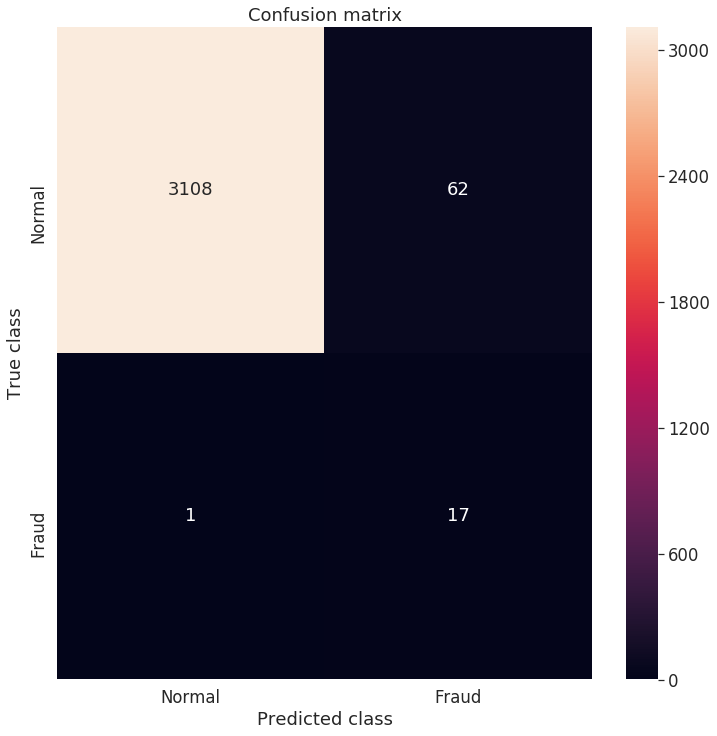

In [23]:
threshold = 2.9
y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)
plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()